# Conversion Rate Challenge
- Objective: Build a model that predicts if a user will subscribe to a newsletter based on information about the user. Explain the behavior of users and improve the conversion rate. Use F-1 score as metric of the model. 

## Imports

In [59]:
# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import random
import datetime

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# save model
import pickle

# show all rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv("/Users/student/Desktop/SupervisedML_ConversionRateChallenge/conversion_data_train.csv")
test = pd.read_csv("/Users/student/Desktop/SupervisedML_ConversionRateChallenge/conversion_data_test.csv")

## Data Exploration

In [4]:
train.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31620 entries, 0 to 31619
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              31620 non-null  object
 1   age                  31620 non-null  int64 
 2   new_user             31620 non-null  int64 
 3   source               31620 non-null  object
 4   total_pages_visited  31620 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


- It will be necessary to change _countr_ and _source_ to categories, in order to save memory and do exploratory analysis.

In [7]:
# change datatype from object to category
train[["country", "source"]] = train[["country", "source"]].astype("category")
test[["country", "source"]] = test[["country", "source"]].astype("category")

# double check
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              284580 non-null  category
 1   age                  284580 non-null  int64   
 2   new_user             284580 non-null  int64   
 3   source               284580 non-null  category
 4   total_pages_visited  284580 non-null  int64   
 5   converted            284580 non-null  int64   
dtypes: category(2), int64(4)
memory usage: 9.2 MB


- Memory went from 13MB to 9.2MB

In [8]:
# missing values
# train, test
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

## EDA
- EDA will be performed only on the training set

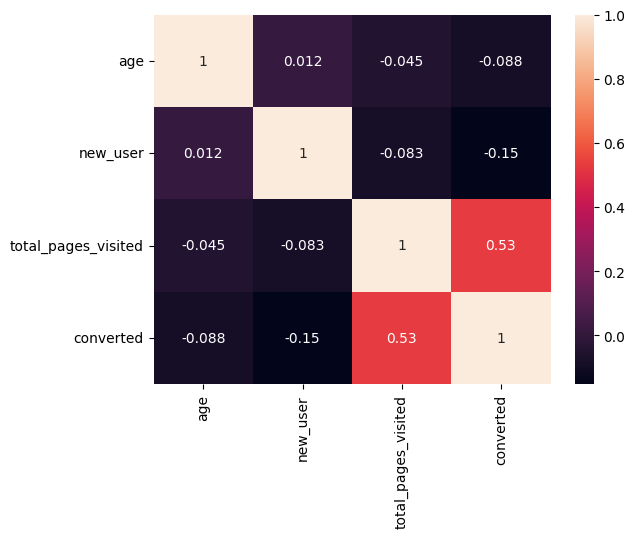

In [9]:
# correlation between variables
train_num = train.select_dtypes("number")
sns.heatmap(train_num.corr(), annot=True)
plt.show()

- There is an important correlation between converted and pages visited that we should look out for.
- This chart does not tell us much as it excludes categorical atribbutes, but we should not be surprised if the variable's coefficient is high when modeling.

### What is the average age of users? Is there a gap between those who subscribe and those who did not?


In [10]:
print(f"Average age of subscribers: {train['age'].mean().round(2)}")

Average age of subscribers: 30.56


In [11]:
converted_age = train[train["converted"]==1]["age"].mean().round(2)
non_converted_age = train[train["converted"]==0]["age"].mean().round(2)
difference_age = (non_converted_age - converted_age).round(2)

print(f"Average age of people who were converted is of {converted_age}, while those who were not is of {non_converted_age}.\
       \nOn average, people who were converted are {difference_age} years younger than those who were not converted.")

Average age of people who were converted is of 26.57, while those who were not is of 30.7.       
On average, people who were converted are 4.13 years younger than those who were not converted.


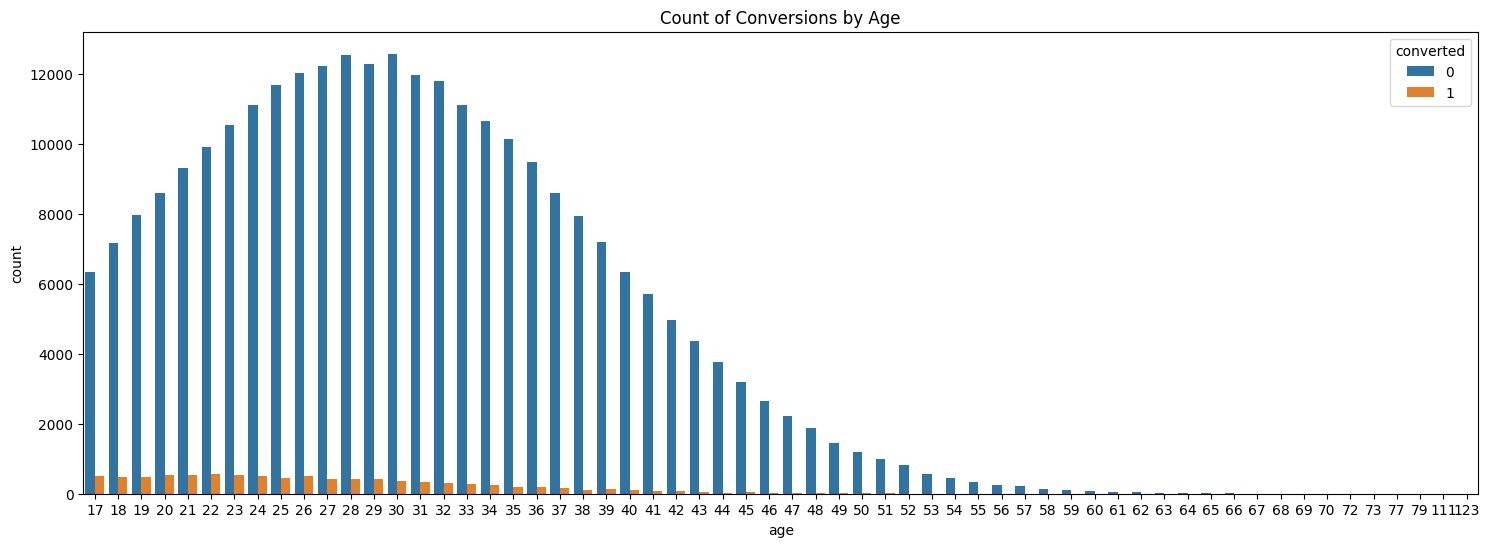

In [12]:
plt.figure(figsize=(18,6))
sns.countplot(data=train,
              x="age",
              hue="converted")
plt.title("Count of Conversions by Age")
plt.show()

In [13]:
# get proportion of conversions by age

# for every age, divide number of conversions between total observations
conversions_age_dict = {}
for age in np.unique(train["age"]):
    conversions_age_dict[age] = len(train[(train["age"]==age) & train["converted"]==1]) / len(train)

conversions_age_df = pd.DataFrame.from_dict(conversions_age_dict, orient="index")
conversions_age_df.rename(columns={0:"Conversion Rate"}, inplace=True)
conversions_age_df.head()

,Conversion Rate
17,0.001739
18,0.001729
19,0.001725
20,0.001845
21,0.001898


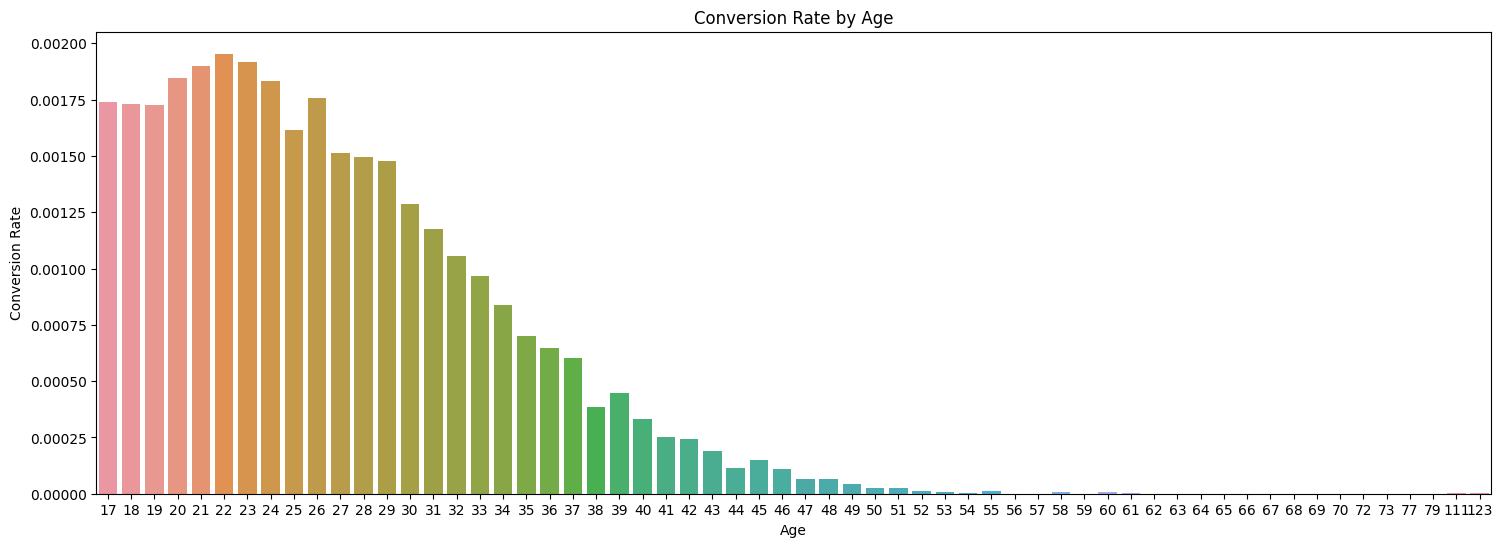

In [14]:
plt.figure(figsize=(18,6))
sns.barplot(data=conversions_age_df,
            x=conversions_age_df.index,
            y="Conversion Rate")
plt.xlabel("Age")
plt.title("Conversion Rate by Age")
plt.show()

##### Insight
- Most subscribers are young, the highest conversion rates are achieved between the ages of 17 and 26. 
- Conversion rate starts to plummet after age of 30. Because of this, it is necessary to focus on people between the ages of 17 and 29. 

### Where are subscribers from?

In [15]:
train["country"].value_counts(1).round(2)

country
US         0.56
China      0.24
UK         0.15
Germany    0.04
Name: proportion, dtype: float64

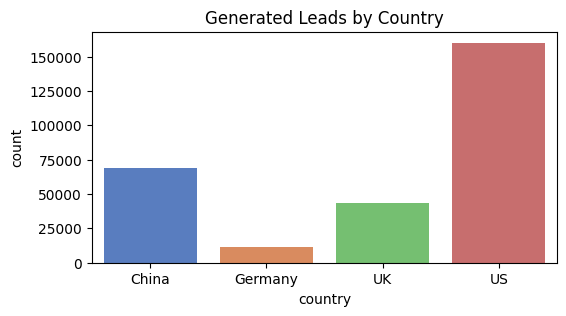

In [16]:
plt.figure(figsize=(6,3))
sns.countplot(data=train,
              x="country",
              palette="muted")
plt.title("Generated Leads by Country")
plt.show()

##### Insight
- More than half are American and only 4% are German. 
- Almost a quarter are Chinese and another 15% are British.

### What is the most used source of conversions?

In [17]:
# percentage of times each source was used
train["source"].value_counts(1).round(2)*100

source
Seo       49.0
Ads       28.0
Direct    23.0
Name: proportion, dtype: float64

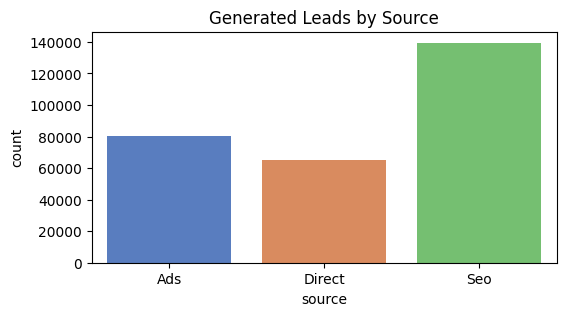

In [18]:
plt.figure(figsize=(6,3))
sns.countplot(data=train,
              x="source",
              palette="muted")
plt.title("Generated Leads by Source")
plt.show()

##### Insight
- SEO is by far the most used source, accounting for almost half of leads.
- Ads and Direct are used similarly, as Ads account for a little more than a quarter of leads, while Direct accounts for a little less than a quarter.

### Which one is the most effective source?

In [19]:
# create dataframe of only converted subscribers
converted = train[train["converted"]==1]
converted["source"].value_counts()

source
Seo       4585
Ads       2785
Direct    1810
Name: count, dtype: int64

In [20]:
# create masked dataframe for every source
# include dataframes of interest for analysis
# if all columns were included, a lot of memory would be taken
seo = train[train["source"]=="Seo"][["source", "converted", "country", "age"]]
ads = train[train["source"]=="Ads"][["source", "converted", "country", "age"]]
direct = train[train["source"]=="Direct"][["source", "converted", "country", "age"]]

In [21]:
# get conversion rate for every source
# multiply by 100 to get percentage

seo_conversion_rate = (seo["converted"].value_counts(1)*100).round(2)[1]
print(f"Conversion rate for SEO is: {seo_conversion_rate}")

ads_conversion_rate = (ads["converted"].value_counts(1)*100).round(2)[1]
print(f"Conversion rate for Ads is: {ads_conversion_rate}")

direct_conversion_rate = (direct["converted"].value_counts(1)*100).round(2)[1]
print(f"Conversion rate for Direct is: {direct_conversion_rate}")

Conversion rate for SEO is: 3.29
Conversion rate for Ads is: 3.48
Conversion rate for Direct is: 2.78


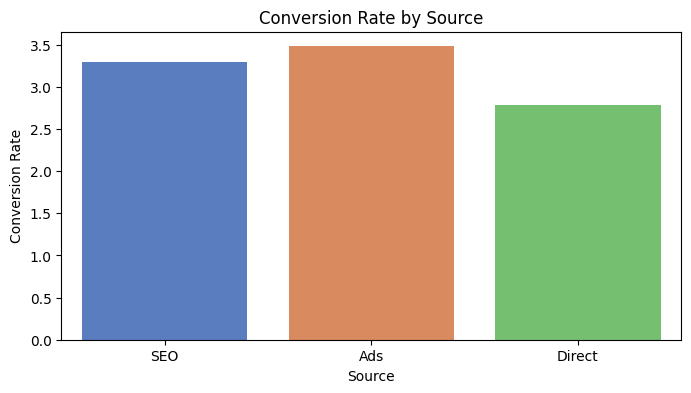

In [22]:
conversions_source_dict = {"SEO":seo_conversion_rate,
                    "Ads":ads_conversion_rate,
                    "Direct":direct_conversion_rate}

conversions_source_df = pd.DataFrame.from_dict(conversions_source_dict, orient="index").rename(columns={0:"Conversion Rate"})

plt.figure(figsize=(8,4))
sns.barplot(data=conversions_source_df,
            x=conversions_source_df.index,
            y="Conversion Rate",
            palette="muted")
plt.xlabel("Source")
plt.title("Conversion Rate by Source")
plt.show()

##### Insight
- Ads are the source with the highest conversion rate, but not by far as SEO is close behind.
- SEO is being used way more than Ads, even though that the latter is more effective. Marketing budgets come in to play, but it could be wise to start using more Ads at the expense of SEO and/or Direct.

### Does conversion by source vary in relation to country?

#### SEO

In [23]:
seo_converted_country_valcounts = seo[["country","converted"]].value_counts()
display(seo_converted_country_valcounts)
print()

# create dataframe from value counts
seo_converted_country_df = pd.DataFrame(seo_converted_country_valcounts).reset_index()
seo_converted_country_df

country  converted
US       0            75376
China    0            33836
UK       0            20296
Germany  0             5384
US       1             3020
UK       1             1154
Germany  1              368
China    1               43
Name: count, dtype: int64

,country,converted,count
0,US,0,75376
1,China,0,33836
2,UK,0,20296
3,Germany,0,5384
4,US,1,3020
5,UK,1,1154
6,Germany,1,368
7,China,1,43


In [24]:
# test
seo_converted_country_df[seo_converted_country_df["country"]=="US"]

,country,converted,count
0,US,0,75376
4,US,1,3020


In [25]:
# create list of countries to use in loop
countries = np.unique(train["country"])
countries

array(['China', 'Germany', 'UK', 'US'], dtype=object)

In [26]:
# test
# for every country create a dataframe that contains only rows with that country
for country in countries:
    df=seo_converted_country_df[seo_converted_country_df["country"]==country]
    display(df)

,country,converted,count
1,China,0,33836
7,China,1,43


,country,converted,count
3,Germany,0,5384
6,Germany,1,368


,country,converted,count
2,UK,0,20296
5,UK,1,1154


,country,converted,count
0,US,0,75376
4,US,1,3020


In [27]:
# create empty dictionary
# for each country create a dataframe that contains only rows with that country
# for each country divide number of converted people into total, to get conversion rate
# in empty dictionary create a key for every country and add conversion rate as value

seo_conversion_rates_country_dict = {}
for country in countries:
    df = seo_converted_country_df[seo_converted_country_df["country"]==country]
    seo_conversion_rates_country_dict[country] = (df.iloc[1].at["count"] / df["count"].sum()).round(4)*100

# convert dictionary to dataframe
seo_conversion_rates_country_df = pd.DataFrame.from_dict(seo_conversion_rates_country_dict, orient="index").rename(columns={0:"conversion_rate"})
seo_conversion_rates_country_df

,conversion_rate
China,0.13
Germany,6.40
UK,5.38
US,3.85


#### Direct
- Repeat exactly same process as SEO

In [28]:
direct_converted_country_valcounts = direct[["country","converted"]].value_counts()
display(direct_converted_country_valcounts)
print()

# create dataframe from value counts
direct_converted_country_df = pd.DataFrame(direct_converted_country_valcounts).reset_index()
direct_converted_country_df

country  converted
US       0            35568
China    0            15705
UK       0             9568
Germany  0             2425
US       1             1201
UK       1              453
Germany  1              137
China    1               19
Name: count, dtype: int64

,country,converted,count
0,US,0,35568
1,China,0,15705
2,UK,0,9568
3,Germany,0,2425
4,US,1,1201
5,UK,1,453
6,Germany,1,137
7,China,1,19


In [29]:
# test
direct_converted_country_df[direct_converted_country_df["country"]=="US"]

,country,converted,count
0,US,0,35568
4,US,1,1201


In [30]:
# create list of countries to use in loop
countries = np.unique(train["country"])
countries

array(['China', 'Germany', 'UK', 'US'], dtype=object)

In [31]:
# test
# for every country create a dataframe that contains only observations with that country
for country in countries:
    df=direct_converted_country_df[direct_converted_country_df["country"]==country]
    display(df)

,country,converted,count
1,China,0,15705
7,China,1,19


,country,converted,count
3,Germany,0,2425
6,Germany,1,137


,country,converted,count
2,UK,0,9568
5,UK,1,453


,country,converted,count
0,US,0,35568
4,US,1,1201


In [32]:
# create empty dictionary
# for each country create a dataframe that contains only rows with that country
# for each country divide number of converted people into total, to get conversion rate
# in empty dictionary create a key for every country and add conversion rate as value

direct_conversion_rates_country_dict = {}
for country in countries:
    df = direct_converted_country_df[direct_converted_country_df["country"]==country]
    direct_conversion_rates_country_dict[country] = (df.iloc[1].at["count"] / df["count"].sum()).round(4)*100

# convert dictionary to dataframe
direct_conversion_rates_country_df = pd.DataFrame.from_dict(direct_conversion_rates_country_dict, orient="index").rename(columns={0:"conversion_rate"})
direct_conversion_rates_country_df

,conversion_rate
China,0.12
Germany,5.35
UK,4.52
US,3.27


#### Ads
- - Repeat exactly same process as SEO and Direct

In [33]:
ads_converted_country_valcounts = ads[["country","converted"]].value_counts()
display(ads_converted_country_valcounts)
print()

# create dataframe from value counts
ads_converted_country_df = pd.DataFrame(ads_converted_country_valcounts).reset_index()
ads_converted_country_df

country  converted
US       0            43110
China    0            19492
UK       0            11486
Germany  0             3154
US       1             1849
UK       1              684
Germany  1              225
China    1               27
Name: count, dtype: int64

,country,converted,count
0,US,0,43110
1,China,0,19492
2,UK,0,11486
3,Germany,0,3154
4,US,1,1849
5,UK,1,684
6,Germany,1,225
7,China,1,27


In [34]:
# test
ads_converted_country_df[ads_converted_country_df["country"]=="US"]

,country,converted,count
0,US,0,43110
4,US,1,1849


In [35]:
# create list of countries to use in loop
countries = np.unique(train["country"])
countries

array(['China', 'Germany', 'UK', 'US'], dtype=object)

In [36]:
# test
# for every country create a dataframe that contains only observations with that country
for country in countries:
    df=ads_converted_country_df[ads_converted_country_df["country"]==country]
    display(df)

,country,converted,count
1,China,0,19492
7,China,1,27


,country,converted,count
3,Germany,0,3154
6,Germany,1,225


,country,converted,count
2,UK,0,11486
5,UK,1,684


,country,converted,count
0,US,0,43110
4,US,1,1849


In [37]:
# create empty dictionary
# for each country create a dataframe that contains only rows with that country
# for each country divide number of converted people into total, to get conversion rate
# in empty dictionary create a key for every country and add conversion rate as value

ads_conversion_rates_country_dict = {}
for country in countries:
    df = ads_converted_country_df[ads_converted_country_df["country"]==country]
    ads_conversion_rates_country_dict[country] = (df.iloc[1].at["count"] / df["count"].sum()).round(4)*100

# convert dictionary to dataframe
ads_conversion_rates_country_df = pd.DataFrame.from_dict(ads_conversion_rates_country_dict, orient="index").rename(columns={0:"conversion_rate"})
ads_conversion_rates_country_df

,conversion_rate
China,0.14
Germany,6.66
UK,5.62
US,4.11


#### Comparison

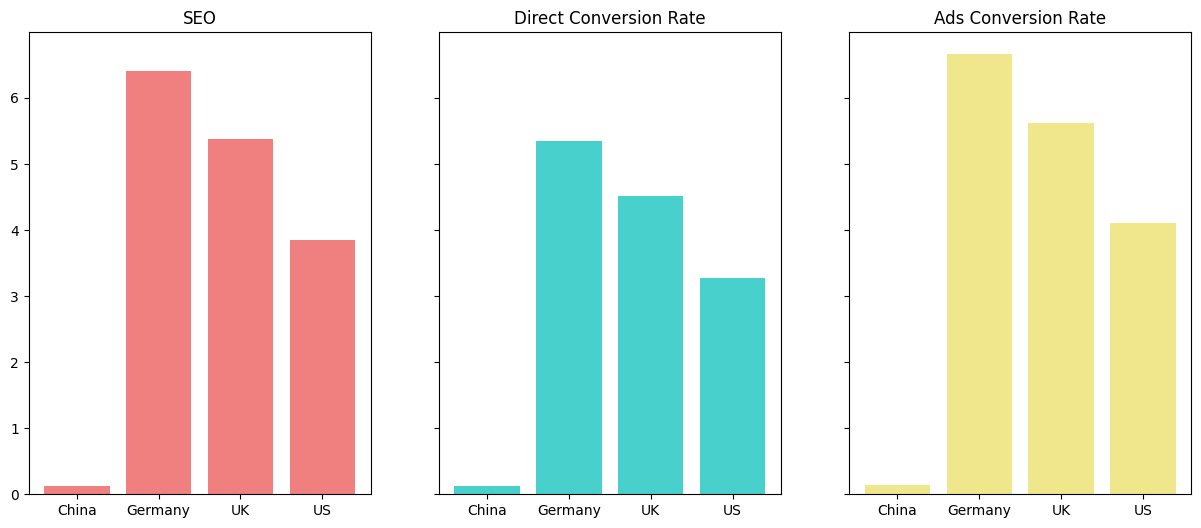

,SEO,Direct,Ads
China,0.13,0.12,0.14
Germany,6.40,5.35,6.66
UK,5.38,4.52,5.62
US,3.85,3.27,4.11


In [38]:
# barplots to compare conversion rates across countries

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(15)

# SEO
ax1.bar(x=seo_conversion_rates_country_df.index,
        height=seo_conversion_rates_country_df["conversion_rate"],
        color="lightcoral")
ax1.set_title("SEO")

# Direct
ax2.bar(x=direct_conversion_rates_country_df.index,
        height=direct_conversion_rates_country_df["conversion_rate"],
        color="mediumturquoise")
ax2.set_title("Direct Conversion Rate")

# Ads
ax3.bar(x=ads_conversion_rates_country_df.index,
        height=ads_conversion_rates_country_df["conversion_rate"],
        color="khaki")
ax3.set_title("Ads Conversion Rate")

# show
plt.show()

# same data presented as a dataframe
# rename columns for identification
seo_conversion_rates_country_df.rename(columns={"conversion_rate":"SEO"}, inplace=True)
direct_conversion_rates_country_df.rename(columns={"conversion_rate":"Direct"}, inplace=True)
ads_conversion_rates_country_df.rename(columns={"conversion_rate":"Ads"}, inplace=True)

frames = [seo_conversion_rates_country_df, direct_conversion_rates_country_df, ads_conversion_rates_country_df]
pd.concat(frames, axis=1)


##### Insight
- Sources are not different by country, as all sources perform the same across countries. Ads is best, followed by SEO and finally Direct.
- Conversion rates do vary though, being Germany the highest, followed by the UK, US and finally China.

#### What is the relationship between number of visited pages and conversions?

In [39]:
# get probability of conversion based on number of visited pages

# for every number of visited pages, divide number of conversions between total observations
conversions_pages_dict = {}
for page in np.unique(train["total_pages_visited"]):
    conversions_pages_dict[page] = len(train[(train["total_pages_visited"]==page) & train["converted"]==1]) / len(train)

conversions_pages_df = pd.DataFrame.from_dict(conversions_pages_dict, orient="index")
conversions_pages_df.rename(columns={0:"Probability"}, inplace=True)
conversions_pages_df.head()

,Probability
1,0.000000
2,0.000032
3,0.000039
4,0.000102
5,0.000179


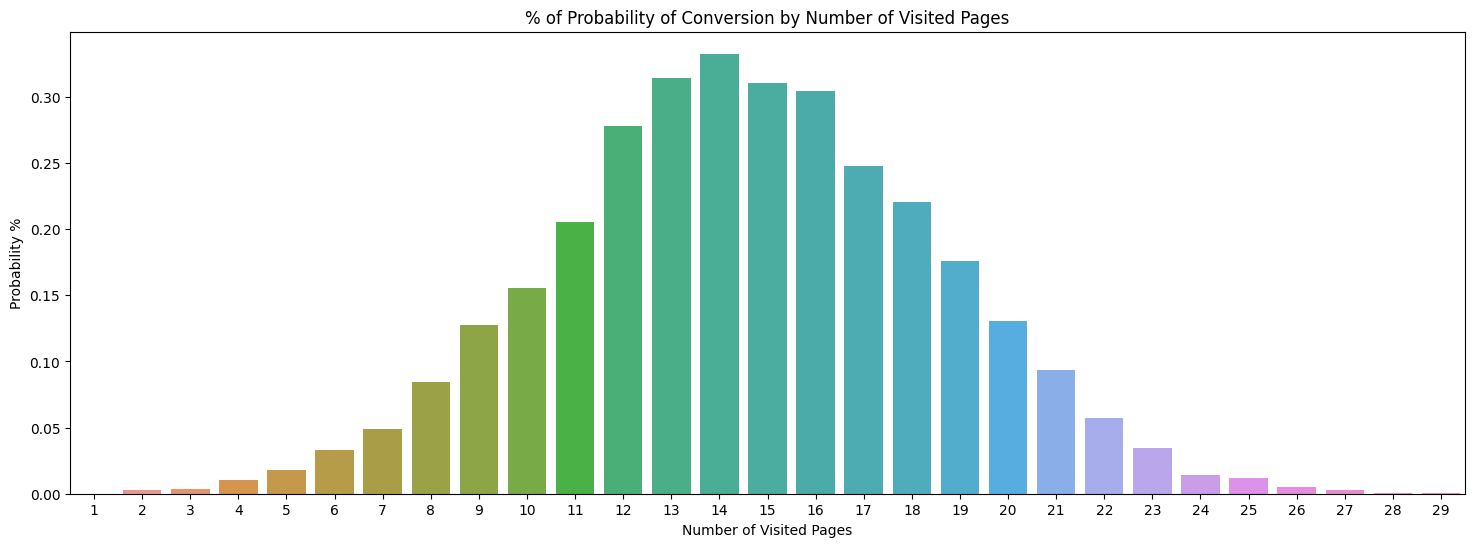

In [40]:
plt.figure(figsize=(18,6))
sns.barplot(data=conversions_pages_df*100,
            x=conversions_pages_df.index,
            y="Probability")
plt.xlabel("Number of Visited Pages")
plt.ylabel("Probability %")
plt.title("% of Probability of Conversion by Number of Visited Pages")
plt.show()

##### Insight
- Intuition suggests that the more pages one visits the higher probability of conversion is, but it is not that way.
- It is true up to a certain point. Between 12 and 17 pages we can observe the highest conversion rates, and after that the rate starts decreasing.

## Preprocessing

In [41]:
train.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


Steps:
- Dummy Variables
- Train-Validation Split (we have another dataset for testing)
- Normalization

In [42]:
# dummy features
train = pd.get_dummies(train, dtype=int, drop_first=True)
# replace bools with 0s and 1s
train = train.replace(False, 0)
train = train.replace(True, 1)
# show
train.head()

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,22,1,2,0,0,0,0,1,0
1,21,1,3,0,0,1,0,0,0
2,20,0,14,1,1,0,0,0,1
3,23,1,3,0,0,0,1,0,1
4,28,1,3,0,0,0,1,1,0


In [49]:
# declare X and y
X = train.drop("converted", axis=1)
y = train["converted"]

# train val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [50]:
# sanity check
X_train.shape, y_train.shape

((227664, 8), (227664,))

In [51]:
# sanity check
X_val.shape, y_val.shape

((56916, 8), (56916,))

## Baseline Model

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.86      0.68      0.76      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.88     56916
weighted avg       0.99      0.99      0.99     56916



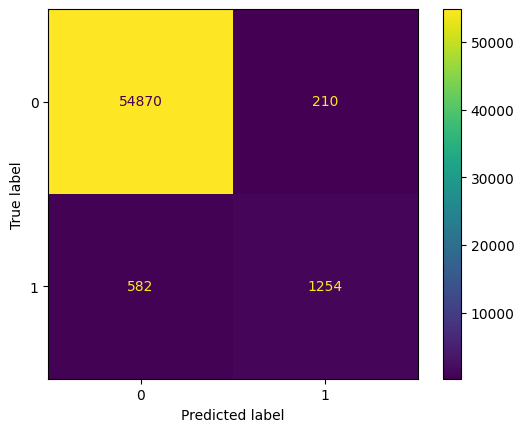

In [62]:
# train model
lg = LogisticRegression(random_state=1)
lg.fit(X_train, y_train)

# metrics
print(classification_report(y_val, lg.predict(X_val)))

# create confusion matrix
cm = confusion_matrix(y_val, lg.predict(X_val), labels=lg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lg.classes_)
disp.plot()


- It has a good performance, with an F1-Score of 77, not bad at all. We are going to try to improve performance by trying different models

## Baseline Model Improvement

LogisticRegression(random_state=1)
 F1-Score: 0.76


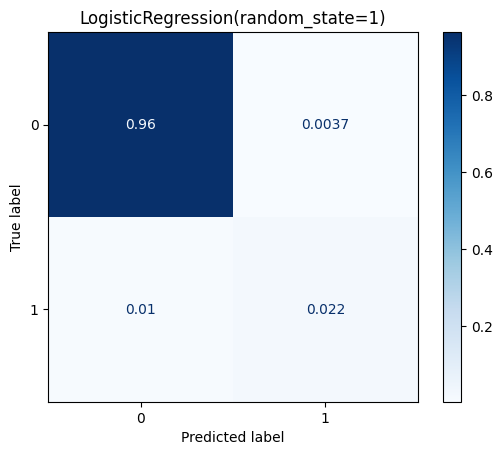


DecisionTreeClassifier(random_state=1)
 F1-Score: 0.718


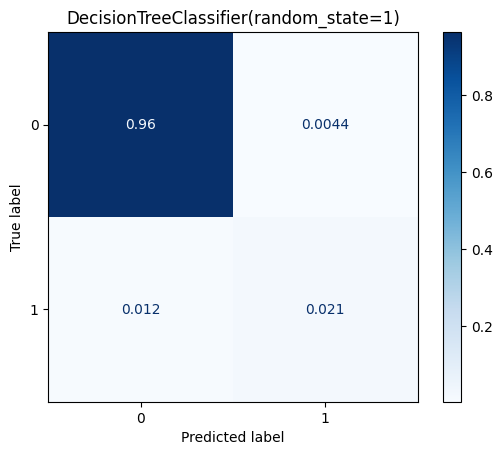


RandomForestClassifier(random_state=1)
 F1-Score: 0.738


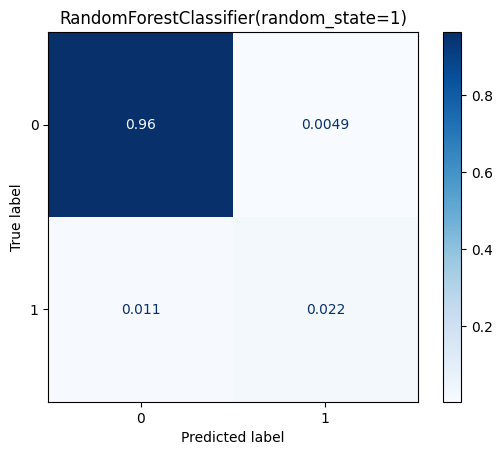


BaggingClassifier(random_state=1)
 F1-Score: 0.732


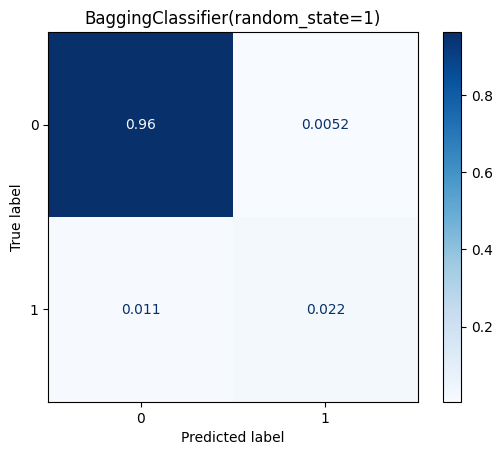


AdaBoostClassifier(random_state=1)
 F1-Score: 0.745


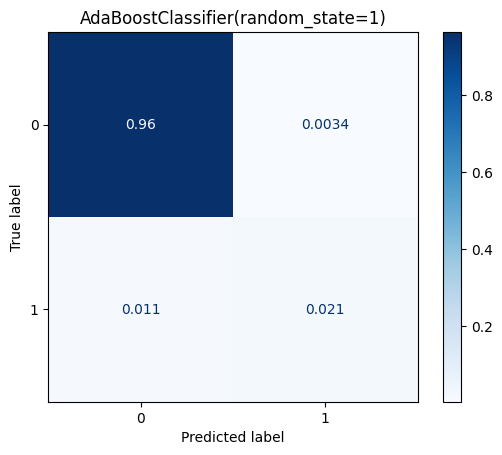


GradientBoostingClassifier(random_state=1)
 F1-Score: 0.758


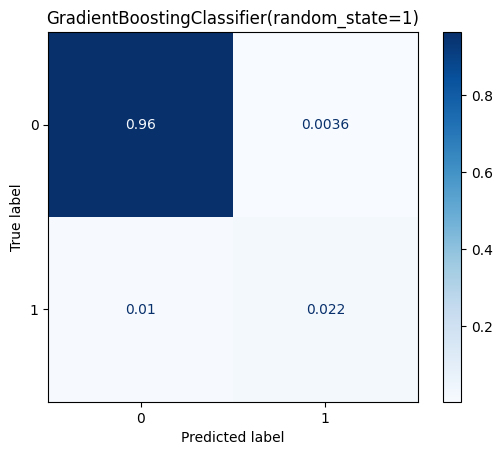


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
 F1-Score: 0.754


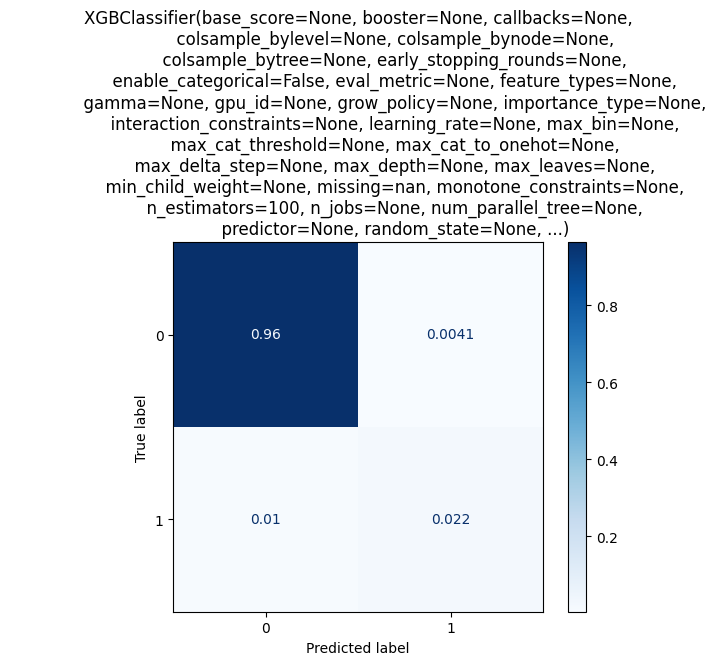

In [86]:
# create classifiers
dt = DecisionTreeClassifier(random_state=1)
rf = RandomForestClassifier(random_state=1)
bag = BaggingClassifier(random_state=1)
adaboost = AdaBoostClassifier(random_state=1)
gradient = GradientBoostingClassifier(random_state=1)
xgb = XGBClassifier()

# create list of models to loop on
models = [lg, dt, rf, bag, adaboost, gradient, xgb]

# create empty list, to append f1 score for each model
f1scores = []

# for loop to train and evaluate models

for model in models:
    # train model
    model.fit(X_train, y_train)

    # metrics (f1 score)
    f1scores.append(f1_score(y_val, model.predict(X_val)).round(3))
    
    # display f1 score
    print(f"{model}\n F1-Score: {f1_score(y_val, model.predict(X_val)).round(3)}")
    
    # display confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, 
                                          normalize="all",
                                          values_format=".2g",
                                          cmap="Blues")                           
    plt.title(model)
    plt.show()
    
    # print just to add space
    print()

In [87]:
f1scores

[0.76, 0.718, 0.738, 0.732, 0.745, 0.758, 0.754]

In [88]:
models = ["lg", "dt", "rf", "bag", "adaboost", "gradient", "xgb"]

# create dictionary with f1 scores
f1scores_dict = dict(zip(models, f1scores))
f1scores_dict

{'lg': 0.76,
 'dt': 0.718,
 'rf': 0.738,
 'bag': 0.732,
 'adaboost': 0.745,
 'gradient': 0.758,
 'xgb': 0.754}

- Very surprisingly, our Baseline model of Logistic Regression had the highest score.
- Adaboost, Gradient Boost and XGBoost had the highest scores after Basekibe. We will test GridSearch on them in order to see if performance can be improved.

## Hyperparameter Tuning

### Gradient Boost

In [91]:
param_grid = {"n_estimators": [100, 150, 200],
              "learning_rate": [0.01, 0.1, 0.25, 0.5],
              "min_samples_split": [4, 6, 8]
              }

gradient_grid_search = GridSearchCV(gradient,
                                    param_grid=param_grid,
                                    cv=5,
                                    n_jobs=-1)

gradient_grid_search.fit(X_train, y_train)

print(gradient_grid_search.best_params_)
print(gradient_grid_search.best_score_.round(4))

{'learning_rate': 0.25, 'min_samples_split': 6, 'n_estimators': 150}
0.9861


In [93]:
gradient_grid_search.best_estimator_

GradientBoostingClassifier(learning_rate=0.25, min_samples_split=6,
                           n_estimators=150, random_state=1)

F1-Score: 0.758


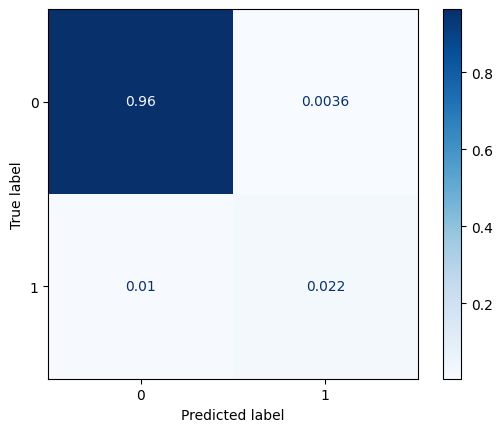

In [95]:
gradient_tuned = gradient_grid_search.best_estimator_
gradient_tuned.fit(X_train, y_train)

print(f"F1-Score: {f1_score(y_val, gradient_tuned.predict(X_val)).round(3)}")
    
# display confusion matrix
ConfusionMatrixDisplay.from_estimator(gradient_tuned, X_val, y_val, 
                                          normalize="all",
                                          values_format=".2g",
                                          cmap="Blues")  
plt.show()   

### Adaboost

In [96]:
param_grid = {"n_estimators": [50, 75, 100, 125, 150, 200],
              "learning_rate": [0.01, 0.1, 0.25, 0.5, 1]
              }

adaboost_grid_search = GridSearchCV(adaboost,
                                    param_grid=param_grid,
                                    cv=5,
                                    n_jobs=-1,)

adaboost_grid_search.fit(X_train, y_train)

print(adaboost_grid_search.best_params_)
print(adaboost_grid_search.best_score_.round(4))

{'learning_rate': 1, 'n_estimators': 200}
0.9861


F1-Score: 0.761


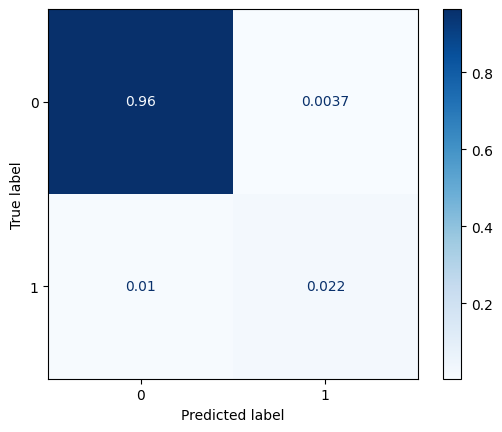

In [97]:
adaboost_tuned = adaboost_grid_search.best_estimator_
adaboost_tuned.fit(X_train, y_train)

print(f"F1-Score: {f1_score(y_val, adaboost_tuned.predict(X_val)).round(3)}")
    
# display confusion matrix
ConfusionMatrixDisplay.from_estimator(adaboost_tuned, X_val, y_val, 
                                      normalize="all",
                                      values_format=".2g",
                                      cmap="Blues")  
plt.show()   

### XGBoost

In [99]:
param_grid = {"n_estimators": [100, 150, 200],
              "eta": [0.01, 0.1, 0.25, 0.5],
              "max_depth": [6, 8, 10]
              }

xgb_grid_search = GridSearchCV(xgb,
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,)

xgb_grid_search.fit(X_train, y_train)

print(xgb_grid_search.best_params_)
print(xgb_grid_search.best_score_.round(4))

{'eta': 0.1, 'max_depth': 6, 'n_estimators': 100}
0.9861


F1-Score: 0.758


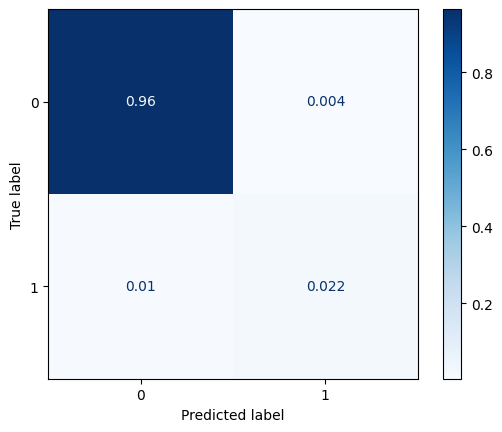

In [101]:
xgb_tuned = xgb_grid_search.best_estimator_
xgb_tuned.fit(X_train, y_train)

print(f"F1-Score: {f1_score(y_val, xgb_tuned.predict(X_val)).round(3)}")
    
# display confusion matrix
ConfusionMatrixDisplay.from_estimator(xgb_tuned, X_val, y_val, 
                                      normalize="all",
                                      values_format=".2g",
                                      cmap="Blues")  
plt.show()   

- The best obtained score is Adaboost, tuned to the best hyperparameters with Grid Search. Impressive as it sounds, it only scored 0.01 more points than the baseline model when it comes to F1-Score. 

In [123]:
cols = train.columns.drop("converted")
cols

Index(['age', 'new_user', 'total_pages_visited', 'country_Germany',
       'country_UK', 'country_US', 'source_Direct', 'source_Seo'],
      dtype='object')

In [128]:
importances_dict = {"variable": cols,
              "importances": adaboost_tuned.feature_importances_}

# create df from dictionary
# sort values descendingly
importances_df = pd.DataFrame.from_dict(importances_dict, orient="index")\
    .T.sort_values(by="importances", ascending=False)
importances_df

,variable,importances
2,total_pages_visited,0.505
0,age,0.28
5,country_US,0.075
4,country_UK,0.07
3,country_Germany,0.05
1,new_user,0.01
6,source_Direct,0.005
7,source_Seo,0.005


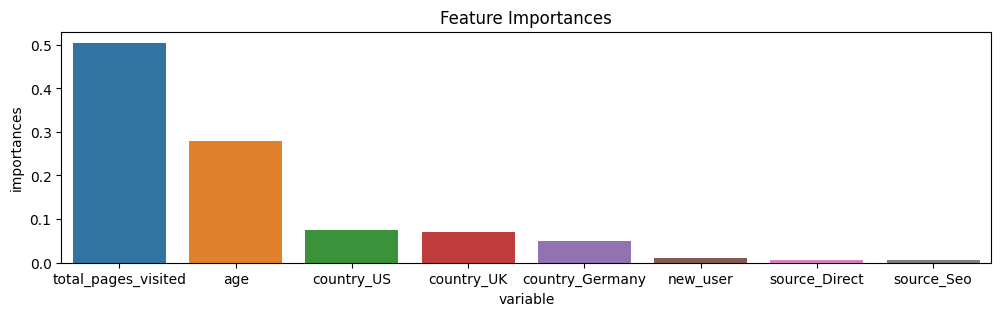

In [133]:
plt.figure(figsize=(12,3))
sns.barplot(data=importances_df,
            x="variable",
            y="importances")
plt.title("Feature Importances")
plt.show()

## Predictions

In [103]:
test.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [104]:
# dummy features
test = pd.get_dummies(test, dtype=int, drop_first=True)
test.head()

,age,new_user,total_pages_visited,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,28,0,16,0,1,0,0,1
1,22,1,5,0,1,0,1,0
2,32,1,1,0,0,0,0,1
3,32,1,6,0,0,1,0,0
4,25,0,3,0,0,0,0,1


In [107]:
test_predictions = pd.Series(adaboost_tuned.predict(test))
test_predictions.head()

0    1
1    0
2    0
3    0
4    0
dtype: int64

In [111]:
test_predictions.value_counts(1).round(3)

0    0.974
1    0.026
Name: proportion, dtype: float64

In [112]:
# save predictions to excel file
test_predictions.to_excel("test_predictions.xlsx")

In [113]:
# save model in file

# name of pickle, format=write binary
adaboost_tuned_pickle = open("adaboost_tuned.pickle", "wb")

# serialization, in other words, convert into a file
pickle.dump(adaboost_tuned, adaboost_tuned_pickle)

# close file
adaboost_tuned_pickle.close()

In [115]:
# test
# open model
open_pickle = open("adaboost_tuned.pickle", "rb")
adaboost_tuned = pickle.load(open_pickle)
adaboost_tuned

AdaBoostClassifier(learning_rate=1, n_estimators=200, random_state=1)

## Conclusions & Recommendations

- According to metrics predictions will be right a tad more than three quarters of the time. It is an estimation but caution is necessary, as not always the same results are translated into production, it will be necessary to track results.
- The model serves as a guide, rather than an absolute veredict. It will help us get an idea who are the most likely candidates to subscribe, so marketing efforts can be focused on these candidates rather than shooting blindly.


- The variables that account for the most explanatory power are pages visited (50.5%), age (28%) and country (19.5%). Marketing source and if the user is new or not do not contribute to predictions.
- The expectation is that the model increases the amount of subscriptions as well as the conversion rate, in order to achieve the ultimate goal which is to grow the newsletter's community.